# Merging Alba and Thonfeld Rasters and Extracting Western Edge Pixels

In [8]:
import rasterio
import rasterio.warp
import rasterio.features
import geopandas as gpd
import numpy as np
import math
import os
import scipy.ndimage as ndi
from rasterio.enums import Resampling
from skimage.morphology import disk
from shapely.geometry import Point, LineString, shape
from tqdm import tqdm
import pickle 



# --- 1. Configuration ---


# --- Input Files ---
# 30m ALBA-Raster (Values 1-15 = Years 2010-2024)
ALBA_DISTURBANCE_PATH = r"..\data\raw\Alba\disturbance_alba_epsg25832_v2.tif"
ALBA_DISTURBANCE_PATH = r"..\data\raw\Alba\disturbance_alba_epsg25832_v2.tif"
# 10m Thonfeld-Raster (Values 1-96 = Months since Sep 2017)
THONFELD_DISTURBANCE_PATH = r"..\data\raw\FrankThonfeld\FCCL_092017-082025_KreiseFichtelgebirge.tif"
# GeoPackage defining the final extent
TEMPLATE_GPKG_PATH = r"..\data\raw\Lancover_bkg_kreis_selected.gpkg"

# Path to the Forest/Non-Forest map (1 = Forest, 0 = Non-Forest)
WALD_OFFENLAND_PATH = r"..\data\raw\Holzbodenkarte\holzbodenkarte_2018_32632.tif"

# --- Output Paths ---
OUTPUT_DIR = r"..\data\edit\Alba_dist_combined_v3"

# 1. Intermediate Product: Combined disturbance (Pixel = Year)
OUTPUT_DISTURBANCE_YEAR_PATH = os.path.join(OUTPUT_DIR, "disturbance_combined_pixel_year_10m.tif")
# 2. Intermediate Product: Final land cover map (0=Non-Forest, 1=Forest, 2=Disturbance)
OUTPUT_LANDCOVER_PATH = os.path.join(OUTPUT_DIR, "final_landcover_map_10m.tif")
# 3. Intermediate Product: Final land cover map (AFTER 3-pixel filter)
OUTPUT_LANDCOVER_PATH = os.path.join(OUTPUT_DIR, "final_landcover_map_filtered_10m.tif")
OUTPUT_LANDCOVER_UNFILTERED_PATH = os.path.join(OUTPUT_DIR, "final_landcover_map_unfiltered_10m.tif")

# 4. Final Product: Vector lines of the transects
OUTPUT_TRANSECTS_PATH = os.path.join(OUTPUT_DIR, "fichtelforst.gpkg")
# 5. Final Product: Vector start points of the transects
OUTPUT_START_POINTS_PATH = os.path.join(OUTPUT_DIR, "fichtelforst.gpkg")
OUTPUT_START_POINTS_LAYER = "punkte_westpixel"


# --- Logic Parameters ---
TARGET_CRS = "EPSG:25832"
TARGET_RES_XY = (10.0, 10.0) # 10m resolution
NODATA_VALUE = -9999
MIN_DISTURBANCE_SIZE_PX = 3 # Areas smaller than 3 pixels will be removed

# Encoding for the final land cover map
LC_NONFOREST = 0
LC_FOREST = 1
LC_DISTURBANCE = 2

# Years for filtering
ALBA_START_YEAR = 2015
ALBA_END_YEAR = 2016
THONFELD_START_YEAR = 2017

# Distances for filtering (in pixels, at 10m resolution)
START_POINT_BUFFER_PX = 10 # 100m
TRANSECT_BUFFER_PX = 20 # 200m
TRANSECT_LENGTH_PX = 10 # 100m

# --- 2. Helper Functions for Year Conversion ---

def map_alba_to_year(value):
    """Converts Alba value (1=2010) to year."""
    if value >= 1 and value <= 15: # 1-15
        return float(value + 2009)
    return 0.0

def map_thonfeld_to_year(month_value):
    """Converts Thonfeld month value (1-96) to year."""
    if month_value >= 1 and month_value <= 96:
        year = 2017 + math.floor((month_value - 1 + 8) / 12)
        return float(year)
    return 0.0

# Vectorize the functions for Numpy arrays
v_map_alba = np.vectorize(map_alba_to_year)
v_map_thonfeld = np.vectorize(map_thonfeld_to_year)

# --- 3. Helper Function for Raster Preparation ---

def reproject_and_match(src_path, bounds, target_crs, target_res, resampling_method, nodata_val, master_profile=None):
    """
    Reprojects a source raster to a target grid.
    If master_profile=None, the grid is calculated from src (for the first call).
    If master_profile is provided, this grid is enforced.
    """
    
    with rasterio.open(src_path) as src:
        src_crs = src.crs
        src_transform = src.transform
        
        if master_profile:
            # Template provided
            # Enforce the dimensions and transformation of the master.
            dst_transform = master_profile['transform']
            dst_width = master_profile['width']
            dst_height = master_profile['height']
            
            # Create profile copy for this call
            dst_profile = master_profile.copy()
            dst_profile.update({
                'dtype': np.float32,
                'nodata': nodata_val
            })
        
        else:
            # 1st call
            # Calculate the grid based on the bounds.
            dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
                src_crs,
                target_crs,
                src.width,
                src.height,
                *src.bounds,
                dst_bounds=bounds,
                resolution=target_res
            )
            
            # Create the profile for the template call
            dst_profile = {
                'driver': 'GTiff',
                'crs': target_crs,
                'transform': dst_transform,
                'width': dst_width,
                'height': dst_height,
                'count': 1,
                'dtype': np.float32,
                'nodata': nodata_val
            }

        # Initialize target array
        dst_array = np.empty((dst_height, dst_width), dtype=np.float32)

        # Perform re-projection
        rasterio.warp.reproject(
            source=rasterio.band(src, 1),
            destination=dst_array,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=target_crs,
            resampling=resampling_method,
            dst_nodata=nodata_val
        )
    
    # Return the array and the calculated or copied profile
    return dst_array, dst_profile

# --- 5. Helper Function for Buffer Kernel ---

def create_transect_buffer_kernel(buffer_px, line_px):
    """
    Creates a boolean mask (kernel) in the form of a 
    rounded-corner buffer around a horizontal line segment (line_px) 
    and its starting pixel (+1).

    Args:
        buffer_px (int): Buffer radius in pixels (e.g., 20 for 200m)
        line_px (int): Length of the transect line in pixels (e.g., 10 for 100m)

    Returns:
        np.ndarray: Boolean 2D kernel.
    """
    
    # The segment to be buffered (line + start pixel) is line_px + 1 pixels long
    # e.g. (c-10) to (c) = 11 pixels
    segment_len = line_px + 1 
    
    # Kernel dimensions (Bounding Box of the buffer)
    # y-axis: buffer | center | buffer -> buffer*2 + 1
    y_dim = buffer_px * 2 + 1
    # x-axis: buffer | segment | buffer -> buffer*2 + segment_len
    x_dim = buffer_px * 2 + segment_len
    
    # Coordinate center in the kernel
    y_center = buffer_px
    x_segment_start = buffer_px
    x_segment_end = buffer_px + line_px # (Segment end is inclusive)
    
    # Create grid with kernel coordinates
    J, I = np.meshgrid(np.arange(x_dim), np.arange(y_dim))
    
    # Calculate distance to the y_center line (axis)
    dy = np.abs(I - y_center)
    
    # Calculate distance to the x-line segment (axis)
    dx = np.zeros_like(J, dtype=float)
    # Left of the segment
    dx[J < x_segment_start] = x_segment_start - J[J < x_segment_start]
    # Right of the segment
    dx[J > x_segment_end] = J[J > x_segment_end] - x_segment_end
    # (Above/Below the segment, dx = 0)
    
    # Calculate Euclidean distance to every point of the segment
    distance = np.sqrt(dx**2 + dy**2)
    
    # Mask: True if distance <= buffer
    kernel = distance <= float(buffer_px)
    
    print(f"  > Buffer kernel created (Size: {kernel.shape}, Distance: {buffer_px}px)")
    return kernel


# --- 4. Main Script ---

def main():
    
    # Ensure the output directory exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Check if the forest map exists
    if not os.path.exists(WALD_OFFENLAND_PATH):
        print(f"ATTENTION ERROR: The Forest/Non-Forest map was not found at: {WALD_OFFENLAND_PATH}")
        print("Please add the path in the configuration and restart the script.")
        return

    print("--- Workflow started ---")
    # --- STEP 1.1: Preparation and Reprojection ---
    print("STEP 1.1: Reading template bounds and reprojecting rasters...")
    
    template_gdf = gpd.read_file(TEMPLATE_GPKG_PATH)
    template_gdf = template_gdf.to_crs(TARGET_CRS)
    target_bounds = template_gdf.total_bounds

    # 1st call (ALBA): Creates the master grid. 
    # 'profile' now stores the master geometry.
    alba_arr, profile = reproject_and_match(
        ALBA_DISTURBANCE_PATH, target_bounds, TARGET_CRS, TARGET_RES_XY, 
        Resampling.nearest, 0 # 0 = NoData/No disturbance
        # master_profile=None is the default here
    )
    
    # 2nd call (Thonfeld): Uses the master grid from Alba
    thonfeld_arr, _ = reproject_and_match(
        THONFELD_DISTURBANCE_PATH, target_bounds, TARGET_CRS, TARGET_RES_XY, 
        Resampling.nearest, 0,
        master_profile=profile
    )
    # replace all np.nan with 0.0
    np.nan_to_num(thonfeld_arr, copy=False, nan=0.0)

    # 3rd call (Forest): Also uses the master grid from Alba
    wald_arr, _ = reproject_and_match(
        WALD_OFFENLAND_PATH, target_bounds, TARGET_CRS, TARGET_RES_XY, 
        Resampling.nearest, NODATA_VALUE,
        master_profile=profile
    )
    
    # 'profile' is the master profile for all subsequent steps
    final_transform = profile['transform']
    final_shape = (profile['height'], profile['width'])
    
    # in case the 1st call (Alba) 
    # had a different dtype (although the function forces float32)
    profile['dtype'] = np.float32

    # --- STEP 1.2: Combining Disturbance Years ---
    print("STEP 1.2: Combining disturbance years (Alba + Thonfeld)...")
    
    alba_year_map = v_map_alba(alba_arr)
    thonfeld_year_map = v_map_thonfeld(thonfeld_arr)

    disturbance_year = np.zeros(final_shape, dtype=np.float32)

    mask_thonfeld = (thonfeld_year_map >= THONFELD_START_YEAR)
    disturbance_year[mask_thonfeld] = thonfeld_year_map[mask_thonfeld]

    mask_alba = (alba_year_map >= ALBA_START_YEAR) & (alba_year_map <= ALBA_END_YEAR)
    disturbance_year[mask_alba] = alba_year_map[mask_alba]

    profile['nodata'] = 0.0
    with rasterio.open(OUTPUT_DISTURBANCE_YEAR_PATH, 'w', **profile) as dst:
        dst.write(disturbance_year.astype(np.float32), 1)

    # --- STEP 1.3: Creating Final Land Cover Map ---
    print("STEP 1.3: Creating final land cover map (With Forest/Non-Forest/Disturbance)...")
    
    lc_map = np.full(final_shape, NODATA_VALUE, dtype=np.int16)
    lc_map[wald_arr != 1] = LC_NONFOREST
    lc_map[wald_arr == 1] = LC_FOREST
    lc_map[disturbance_year > 0] = LC_DISTURBANCE

    # Save the UNFILTERED land use map
    print(f"  > Saving UNFILTERED land use map to: {OUTPUT_LANDCOVER_UNFILTERED_PATH}")
    profile['dtype'] = np.int16
    profile['nodata'] = NODATA_VALUE
    with rasterio.open(OUTPUT_LANDCOVER_UNFILTERED_PATH, 'w', **profile) as dst:
        dst.write(lc_map, 1)

    # --- STEP 2.1: Filtering disturbance areas. Smaller than 3 Pix ---
    print(f"STEP 2.1: Filtering disturbance areas smaller than {MIN_DISTURBANCE_SIZE_PX} pixels...")
    
    is_disturbance_mask = (lc_map == LC_DISTURBANCE)
    
    structure = ndi.generate_binary_structure(2, 2)
    labeled_array, num_features = ndi.label(is_disturbance_mask, structure=structure)
    
    print(f"  > {num_features} disturbance areas found (before filtering).")

    labels, counts = np.unique(labeled_array, return_counts=True)
    
    small_labels = labels[counts < MIN_DISTURBANCE_SIZE_PX]
    small_labels = small_labels[small_labels != 0]

    if len(small_labels) > 0:
        lc_map[np.isin(labeled_array, small_labels)] = LC_FOREST
        print(f"  > {len(small_labels)} small areas removed and reclassified as Forest.")

    is_disturbance_cleaned = (lc_map == LC_DISTURBANCE)
    # Recalculate label array for Step 2.4
    labeled_array_cleaned, num_features_cleaned = ndi.label(is_disturbance_cleaned, structure=structure)

    profile['dtype'] = np.int16
    profile['nodata'] = NODATA_VALUE
    with rasterio.open(OUTPUT_LANDCOVER_PATH, 'w', **profile) as dst:
        dst.write(lc_map, 1)


    # 1. Save the array with patch IDs as a NumPy file
    patch_id_array_path = os.path.join(OUTPUT_DIR, "final_patch_ids.npy")
    np.save(patch_id_array_path, labeled_array_cleaned)
    print(f"  > Patch-ID array saved to: {patch_id_array_path}")

    # 2. Save the geotransformation (important for x/y -> r/c)
    # (Make the 'transform' object serializable)
    transform_path = os.path.join(OUTPUT_DIR, "final_transform.pkl")
    # 'final_transform' is a variable from Step 1.1
    with open(transform_path, 'wb') as f:
        pickle.dump(final_transform, f)
    print(f"  > Geotransformation saved to: {transform_path}")

    # --- STEP 2.2: Finding Western Edge Pixels ---
    print("STEP 2.2: Finding western edge pixels of the disturbance areas...")
    
    is_disturbance = (lc_map == LC_DISTURBANCE)
    is_not_disturbance = (lc_map != LC_DISTURBANCE)
    
    west_neighbor_not_disturbance = np.roll(is_not_disturbance, shift=1, axis=1)
    west_neighbor_not_disturbance[:, 0] = False

    candidate_edge_pixels = is_disturbance & west_neighbor_not_disturbance

    # --- STEP 2.3: Filtering Start Pixels (100m Buffer) ---
    print(f"STEP 2.3: Filtering start pixels (no non-forest within 100m radius)...")
    
    is_non_forest = (lc_map == LC_NONFOREST)
    footprint_100m = disk(START_POINT_BUFFER_PX)
    dilated_non_forest_100m = ndi.binary_dilation(is_non_forest, structure=footprint_100m)

    valid_start_pixels_mask = candidate_edge_pixels & ~dilated_non_forest_100m
    
    start_rows, start_cols = np.where(valid_start_pixels_mask)
    print(f"  > {len(start_rows)} valid start pixels found after 100m filtering.")

    if len(start_rows) == 0:
        print("No valid start pixels found. Terminating workflow.")
        return
    
    # --- PREPARATION FOR STEP 2.4: Creating Buffer Kernel ---
    
    # Get array dimensions for edge checks
    max_row, max_col = lc_map.shape
    
    # Define radii/lengths in pixels
    BUFFER_RADIUS_PX = 20 # 200m
    TRANSECT_LEN_PX_LINE = 10 # 100m
    
    print("STEP 2.4 (Pre-Cache): Creating 200m (20px) transect buffer kernel...")
    
    # Create the Euclidean/rounded kernel.
    # It buffers the 10px line AND the 1px start pixel (i.e., 11 pixel segment)
    BUFFER_KERNEL = create_transect_buffer_kernel(BUFFER_RADIUS_PX, TRANSECT_LEN_PX_LINE)
    
    # Kernel offsets (center point relative to the (0,0) corner of the kernel)
    # (r, c) (start pixel) corresponds to kernel coordinate (y_center, x_segment_end)
    KERNEL_Y_OFFSET = BUFFER_RADIUS_PX # 20
    # Kernel(0,0) is at (c - 10(line) - 20(buffer))
    KERNEL_X_OFFSET_LEFT = TRANSECT_LEN_PX_LINE + BUFFER_RADIUS_PX # 10 + 20 = 30
    
    # --- STEP 2.4: Raster-based Transect Filtering ---
    print(f"STEP 2.4: Generating and filtering transects (kernel-based)...")

    final_transects_data = []

    # Use tqdm for progress indication
    for r, c in tqdm(zip(start_rows, start_cols), total=len(start_rows), desc="Filtering Transects (Raster)"):
        
        # 1. Get ID of the current disturbance area
        current_disturbance_id = labeled_array_cleaned[r, c]
        
        # 2. CHECK A (Transect Line): 
        if (c - TRANSECT_LEN_PX_LINE) < 0:
            continue # if transect exits the raster to the left
            
        transect_labels = labeled_array_cleaned[r, (c - TRANSECT_LEN_PX_LINE) : c]
        if np.any(transect_labels > 0):
            continue

        # 3. CHECK B (200m Rounded-Buffer-Check with Kernel):
        
        # Define the absolute bounding box of the buffer kernel
        # Y-axis
        r_min_abs = r - KERNEL_Y_OFFSET # r - 20
        r_max_abs = r + KERNEL_Y_OFFSET + 1 # r + 21 (for 41 pixels)
        
        # X-axis
        # Kernel(0,0) -> c - 30
        c_min_abs = c - KERNEL_X_OFFSET_LEFT # c - 30
        c_max_abs = c - KERNEL_X_OFFSET_LEFT + BUFFER_KERNEL.shape[1] # (c - 30) + 51 -> c + 21
        
        # Find valid (overlapping) indices (clipping at the raster edge)
        r_min_valid = max(0, r_min_abs)
        r_max_valid = min(max_row, r_max_abs)
        c_min_valid = max(0, c_min_abs)
        c_max_valid = min(max_col, c_max_abs)
        
        # If the slice has invalid dimensions (e.g., 0), skip
        if (r_max_valid <= r_min_valid) or (c_max_valid <= c_min_valid):
            continue

        # Calculate the corresponding slices for the kernel itself
        k_r_min = r_min_valid - r_min_abs
        k_r_max = k_r_min + (r_max_valid - r_min_valid)
        k_c_min = c_min_valid - c_min_abs
        k_c_max = k_c_min + (c_max_valid - c_min_valid)

        # Get the slices from the main arrays and the kernel
        try:
            lc_map_window = lc_map[r_min_valid:r_max_valid, c_min_valid:c_max_valid]
            labels_window = labeled_array_cleaned[r_min_valid:r_max_valid, c_min_valid:c_max_valid]
            kernel_window = BUFFER_KERNEL[k_r_min:k_r_max, k_c_min:k_c_max]
        except IndexError:
            # Safety catch in case slicing fails
            continue

        # CHECK B.1: Is Non-Forest (LC_NONFOREST) in the kernel buffer?
        # Apply boolean mask (kernel_window) to the array
        if np.any(lc_map_window[kernel_window] == LC_NONFOREST):
            continue

        # CHECK B.2: Is ANOTHER disturbance in the kernel buffer?
        # Apply mask to get only pixels within the buffer
        labels_in_buffer = labels_window[kernel_window]
        
        # Check these pixels for disturbance areas other than the current one
        other_disturbance_mask = (labels_in_buffer > 0) & (labels_in_buffer != current_disturbance_id)
        if np.any(other_disturbance_mask):
            continue

        # --- If all checks are passed ---
        # Create vector data (points, lines)
        start_x, start_y = final_transform * (c + 0.5, r + 0.5)
        # 100m = TRANSECT_LEN_PX_LINE (10)
        end_x, end_y = final_transform * (c - TRANSECT_LEN_PX_LINE + 0.5, r + 0.5)
        
        start_point_geom = Point(start_x, start_y)
        transect_line_geom = LineString([start_point_geom, Point(end_x, end_y)])

        final_transects_data.append({
            'geometry': transect_line_geom,
            'start_point_geom': start_point_geom,
            'disturbance_id': current_disturbance_id,
            'start_row': r,
            'start_col': c
        })

    print(f"  > {len(final_transects_data)} valid transects generated after raster filtering.")

    # --- STEP 2.5: Saving Results ---
    if final_transects_data:
        # Save transects
        transects_gdf = gpd.GeoDataFrame(
            final_transects_data, 
            geometry='geometry', 
            crs=TARGET_CRS
        )
        transects_gdf.drop(columns=['start_point_geom'], inplace=True)
        transects_gdf.to_file(OUTPUT_TRANSECTS_PATH, driver="GPKG")
        print(f"  > Final transects saved to: {OUTPUT_TRANSECTS_PATH}")

        # Save start points
        start_points_gdf = gpd.GeoDataFrame(
            final_transects_data, 
            geometry='start_point_geom', 
            crs=TARGET_CRS
        )
        start_points_gdf.drop(columns=['geometry'], inplace=True)
        start_points_gdf.to_file(OUTPUT_START_POINTS_PATH, layer=OUTPUT_START_POINTS_LAYER, driver="GPKG")
        print(f"  > Start points saved to: {OUTPUT_START_POINTS_PATH}, Layer: {OUTPUT_START_POINTS_LAYER}")
    else:
        print("No transects met all filter criteria.")

    print("--- Workflow completed ---")


if __name__ == "__main__":
    main()

--- Workflow started ---
STEP 1.1: Reading template bounds and reprojecting rasters...
STEP 1.2: Combining disturbance years (Alba + Thonfeld)...
STEP 1.3: Creating final land cover map (With Forest/Non-Forest/Disturbance)...
  > Saving UNFILTERED land use map to: ..\data\edit\Alba_dist_combined_v3\final_landcover_map_unfiltered_10m.tif
STEP 2.1: Filtering disturbance areas smaller than 3 pixels...
  > 54754 disturbance areas found (before filtering).
  > 30127 small areas removed and reclassified as Forest.
  > Patch-ID array saved to: ..\data\edit\Alba_dist_combined_v3\final_patch_ids.npy
  > Geotransformation saved to: ..\data\edit\Alba_dist_combined_v3\final_transform.pkl
STEP 2.2: Finding western edge pixels of the disturbance areas...
STEP 2.3: Filtering start pixels (no non-forest within 100m radius)...
  > 73686 valid start pixels found after 100m filtering.
STEP 2.4 (Pre-Cache): Creating 200m (20px) transect buffer kernel...
  > Buffer kernel created (Size: (41, 51), Distance:

Filtering Transects (Raster): 100%|██████████| 73686/73686 [00:03<00:00, 22677.31it/s]


  > 2331 valid transects generated after raster filtering.
  > Final transects saved to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg
  > Start points saved to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg, Layer: punkte_westpixel
--- Workflow completed ---


# Determine Disturbance Area in Hectares

In [4]:
import os
import sys
import geopandas as gpd
import rasterio
import rasterio.transform
import numpy as np
import scipy.ndimage as ndi
from rasterio.features import geometry_mask

# --- 1. Configuration ---

# Path to the disturbance raster (Pixels 2015-2025 are disturbances)
RASTER_PATH = r"..\data\edit\Alba_dist_combined_v3\disturbance_combined_pixel_year_10m.tif"

# --- Path to Point File
POINTS_PATH = r"..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg"
POINTS_LAYER_NAME = "punkte_westpixel" 

# Name of the new column for the area in hectares
AREA_COLUMN_NAME = 'Area_ha'

# Name for the output file (will be saved in the same folder as the point file)
OUTPUT_LAYER_NAME = "punkte_westpixel_ha"


# --- 2. Main Script ---

def add_patch_area_to_points():
    print("--- Starting area calculation for disturbance points ---")
    
    # --- Step 1: Load raster and segment disturbance areas ---
    try:
        print(f"Reading raster: {RASTER_PATH}")
        with rasterio.open(RASTER_PATH) as src:
            data = src.read(1)
            transform = src.transform
            crs = src.crs
            profile = src.profile # Metadata for later use
            
            # Calculate pixel area
            pixel_area_m2 = abs(transform.a * transform.e)
            if pixel_area_m2 == 0:
                print("Attention !!! ERROR: Pixel area is 0. Transformation invalid.")
                return False
            pixel_area_ha = pixel_area_m2 / 10000.0
            print(f"  Raster CRS: {crs}, Pixel Area: {pixel_area_m2} m² ({pixel_area_ha} ha)")

            # Mask for disturbance pixels (1-2026)
            clearing_mask = (data >= 1) & (data <= 2026)
            
            # Segmenting disturbance areas
            print("Segmenting disturbance areas...")
            # `structure` defines neighborhood (here 8-connectivity)
            structure = ndi.generate_binary_structure(2, 2) 
            labeled_patches, num_features = ndi.label(clearing_mask, structure=structure)
            print(f"  {num_features} connected disturbance areas found.")

            if num_features == 0:
                print("ATTENTION ERROR!?: No disturbance areas found in the raster.")
            
            # IMPORTANT: Keep transform and labeled_patches in memory for later use
            # (they will be needed after the context manager closes)
            
    except FileNotFoundError:
        print(f"ERROR: Raster file not found: {RASTER_PATH}")
        return False
    except Exception as e:
        print(f"ERROR while reading or segmenting the raster: {e}")
        return False

    # --- Step 2: Calculate area per segment ---
    print("Calculating area per segment...")
    patch_areas_ha = {} # Dictionary: {patch_id: area_in_ha}
    
    if num_features > 0:
        # Find all unique patch IDs (except 0 = background)
        unique_labels = np.unique(labeled_patches)
        valid_labels = unique_labels[unique_labels != 0]
        
        # Count pixels per patch ID
        labels, counts = np.unique(labeled_patches, return_counts=True)
        
        # Create the dictionary
        for label, count in zip(labels, counts):
            if label != 0: # Ignore forest
                 patch_areas_ha[label] = round(count * pixel_area_ha, 4)
                 
        print(f"  Areas calculated for {len(patch_areas_ha)} segments.")
        
        # Optional: Output Min/Max area
        if patch_areas_ha:
             min_area = min(patch_areas_ha.values())
             max_area = max(patch_areas_ha.values())
             print(f"  Min. Area: {min_area:.4f} ha, Max. Area: {max_area:.2f} ha")
        
    # --- Step 3: Load points and check/adjust CRS ---
    try:
        print(f"Reading point file: {POINTS_PATH}")
        points_layer_name = None
        if 'POINTS_LAYER_NAME' in globals():
             points_layer_name = POINTS_LAYER_NAME
             print(f"  Using layer: {points_layer_name}")
             
        points_gdf = gpd.read_file(POINTS_PATH, layer=points_layer_name)
        print(f"  {len(points_gdf)} points found.")
        print(f"  Points CRS: {points_gdf.crs}")
        
        # Compare CRS and adjust if necessary
        if points_gdf.crs != crs:
            print(f"WARNING: CRS of points ({points_gdf.crs}) differs from raster CRS ({crs}). Reprojecting points...")
            try:
                points_gdf = points_gdf.to_crs(crs)
                print(f"  Points successfully reprojected to {crs}.")
            except Exception as e:
                print(f"ERROR during CRS transformation of points: {e}")
                print("Ensure both layers have valid CRS.")
                return False
                
    except FileNotFoundError:
        print(f"ERROR: Point file not found: {POINTS_PATH}")
        return False
    except Exception as e:
        print(f"ERROR while reading the point file: {e}")
        return False

    # --- Step 4: Extract area for each point ---
    print("Extracting area IDs for each point...")
    point_patch_ids = []
    
    # Extract coordinates as a list of tuples
    coords = [(p.x, p.y) for p in points_gdf.geometry]
    
    # Use the transform stored in memory to extract patch IDs
    try:
        # Sample directly from the labeled_patches array using the transform
        for x, y in coords:
            # Convert coordinates to row/column using the transform
            row, col = rasterio.transform.rowcol(transform, x, y)
            # Check if index is within raster bounds
            if 0 <= row < labeled_patches.shape[0] and 0 <= col < labeled_patches.shape[1]:
                point_patch_ids.append(int(labeled_patches[row, col]))
            else:
                point_patch_ids.append(0) # Point outside -> ID 0
        print(f"  Patch IDs extracted for {len(point_patch_ids)} points.")
        
    except Exception as e:
         print(f"ERROR while sampling raster values at point locations: {e}")
         # Fallback
         print("Attempting manual sampling (slower)...")
         point_patch_ids = []
         try:
             for x, y in coords:
                 # Convert coordinates to row/column
                 row, col = rasterio.transform.rowcol(transform, x, y)
                 # Check if index is within raster bounds
                 if 0 <= row < labeled_patches.shape[0] and 0 <= col < labeled_patches.shape[1]:
                      point_patch_ids.append(int(labeled_patches[row, col]))
                 else:
                      point_patch_ids.append(0) # Point outside -> ID 0
             print(f"  Manual sampling for {len(point_patch_ids)} points completed.")
         except Exception as e_inner:
             print(f"ERROR also during manual sampling: {e_inner}")
             return False

    # --- Step 5: Assign areas and save ---
    print(f"Assigning areas to the new column '{AREA_COLUMN_NAME}'...")
    
    # Use the extracted patch IDs to get the areas from the dictionary
    # .get(id, 0) returns 0 if the ID is not in the dict (e.g., for ID 0 or errors)
    areas_for_points = [patch_areas_ha.get(patch_id, 0) for patch_id in point_patch_ids]
    
    # New column to GeoDataFrame
    points_gdf[AREA_COLUMN_NAME] = areas_for_points
    points_gdf.head()
    
    # Create path for the output file
    output_path = POINTS_PATH
    
    try:
        print(f"Saving result to: {output_path} layer: {OUTPUT_LAYER_NAME}...")
        points_gdf.to_file(output_path, layer=OUTPUT_LAYER_NAME, driver="GPKG")
        print("  Successfully saved.")
        return True
    except Exception as e:
        print(f"ERROR while saving the result file: {e}")
        return False

# --- 3. Execute Script ---
if __name__ == "__main__":
    success = add_patch_area_to_points()


    
    print("\n---------------------------------")
    if success:
        print("Script finished successfully.")
    else:
        print("Script finished with errors.")

--- Starting area calculation for disturbance points ---
Reading raster: ..\data\edit\Alba_dist_combined_v3\disturbance_combined_pixel_year_10m.tif
  Raster CRS: EPSG:25832, Pixel Area: 100.0 m² (0.01 ha)
Segmenting disturbance areas...
  54754 connected disturbance areas found.
Calculating area per segment...
  Areas calculated for 54754 segments.
  Min. Area: 0.0100 ha, Max. Area: 284.90 ha
Reading point file: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg
  Using layer: punkte_westpixel
  2331 points found.
  Points CRS: EPSG:25832
Extracting area IDs for each point...
  Patch IDs extracted for 2331 points.
Assigning areas to the new column 'Area_ha'...
Saving result to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg layer: punkte_westpixel_ha...
  Successfully saved.

---------------------------------
Script finished successfully.


# Add Topographic (TWI, Slope, Height) and Disturbance (Year) Metrics

Metrics are calculated at three scales:
- Value at the exact point location
- Median value of the 100m neighborhood (within the same patch)
- Median value of the entire disturbance patch

In [60]:
import geopandas as gpd
import rasterio
import rasterio.warp
from rasterio.enums import Resampling
import numpy as np
import pickle
from scipy.ndimage import median as nd_median
from tqdm import tqdm
import os

print("--- Extended statistics script started ---")

# --- 1. Configuration ---

# Directory Paths
BASE_DIR = r"..\data\edit\Alba_dist_combined_v3"
WBT_DIR = r"..\data\edit\DGM\WBT_Output"
DEM_PATH = r"..\data\edit\DGM\DGM_merg_10m.tif"

# Input: Points with area
POINTS_PATH = os.path.join(BASE_DIR, "fichtelforst.gpkg")
POINTS_LAYER = "punkte_westpixel_ha"


# Input: Files from the previous processing step
PATCH_ID_ARRAY_PATH = os.path.join(BASE_DIR, "final_patch_ids.npy")
TRANSFORM_PATH = os.path.join(BASE_DIR, "final_transform.pkl")

# Input: Rasters to be sampled
RASTER_TO_SAMPLE = {
    "Hoehe": DEM_PATH,
    "SCA": os.path.join(WBT_DIR, "02_wbt_sca.tif"),
    "Slope": os.path.join(WBT_DIR, "03_wbt_slope_radians.tif"),
    "TWI": os.path.join(WBT_DIR, "04_wbt_TWI.tif"),
    "Year": os.path.join(BASE_DIR, "disturbance_combined_pixel_year_10m.tif")
}

# Parameters for neighborhood median
NEIGHBORHOOD_RADIUS_PX = 10 # 10 pixels = 100m

# Output
OUTPUT_PATH = POINTS_PATH
OUTPUT_LAYER = "punkte_westpixel_ha_stats"


# --- 2. Load Data ---

print(f"Loading points: {POINTS_PATH}")
try:
    points_gdf = gpd.read_file(POINTS_PATH, layer=POINTS_LAYER)
except Exception as e:
    print(f"ERROR: Could not load layer '{POINTS_LAYER}'. Attempting to load 'valid_transect_start_points' instead...")
    try:
        points_gdf = gpd.read_file(
            os.path.join(BASE_DIR, "valid_transect_start_points.gpkg"), 
            layer="valid_transect_start_points"
        )
    except Exception as e_inner:
        print(f"Could not load original points Gpkg: {e_inner}")
        exit()

print(f"Loading Patch-ID array: {PATCH_ID_ARRAY_PATH}")
patch_id_array = np.load(PATCH_ID_ARRAY_PATH)

print(f"Loading Master-Transformation: {TRANSFORM_PATH}")
with open(TRANSFORM_PATH, 'rb') as f:
    # Master transformation
    transform = pickle.load(f)

# --- Determine Master CRS ---
master_crs = None
year_raster_path = RASTER_TO_SAMPLE.get("Year")
if not year_raster_path:
    print("ERROR: 'Year' raster must be defined in RASTER_TO_SAMPLE.")
    exit()

try:
    with rasterio.open(year_raster_path) as src:
        master_crs = src.crs
        print(f"Master CRS (from 'Year' raster) determined: {master_crs}")
except Exception as e:
    print(f"ERROR: Could not open 'Year' raster to read Master CRS: {e}")
    exit()

# --- Reproject points to Master CRS ---
if points_gdf.crs != master_crs:
    print(f"Reprojecting points from {points_gdf.crs} to {master_crs}...")
    points_gdf = points_gdf.to_crs(master_crs)
else:
    print("Points are already in Master CRS.")

# Load all raster arrays
raster_data = {}
for name, path in RASTER_TO_SAMPLE.items():
    print(f"Loading raster array: {name}...")
    with rasterio.open(path) as src:
        raster_data[name] = {
            "array": src.read(1),
            "nodata": src.nodata
        }

print("All data loaded.")

# --- 3. Calculate Pixel Coordinates (r, c) for points ---
print("Calculating pixel coordinates (r, c) for all points...")

# since points_gdf is in Master CRS, they are (x, y)
coords_xy_master = [(p.x, p.y) for p in points_gdf.geometry]

# and 'transform' is the Master transformation, they are (r, c)
px_coords_master = [rasterio.transform.rowcol(transform, x, y) for x, y in coords_xy_master]

# Save the indices in the GDF
points_gdf['px_row'] = [r for r, c in px_coords_master]
points_gdf['px_col'] = [c for r, c in px_coords_master]

print("Pixel coordinates calculated successfully.")

# --- 4. Calculate Metrics ---
# Array dimensions and the profile of the Master Grid
max_row, max_col = patch_id_array.shape
master_profile = {
    'driver': 'GTiff',
    'crs': master_crs,
    'transform': transform,
    'width': max_col,
    'height': max_row,
    'count': 1,
    'dtype': np.float32, # Target dtype for reprojection
    'nodata': -9999
}
master_shape = (max_row, max_col)

# Coordinates for rasterio.sample
coords = [(p.x, p.y) for p in points_gdf.geometry]

# Iterate over each raster to be sampled
for name, data in raster_data.items():
    print(f"--- Processing raster: {name} ---")
    
    # Get the source data
    source_array = data['array']
    source_nodata = data['nodata']
    
    # --- METRIC 1: Value at the exact pixel (via rasterio.sample) ---
    print("Calculating Metric 1: Point value...")
    col_name_point = f"{name}_Point"
    
    # Re-open the source file to use .sample()
    with rasterio.open(RASTER_TO_SAMPLE[name]) as src:
        # src.sample() is robust against grid mismatches
        sampled_values = list(src.sample(coords))
        point_values = [val[0] for val in sampled_values]
        
    points_gdf[col_name_point] = point_values

    # --- Preparation for Metric 2 & 3: Reprojection ---
    
    # Check if the source raster is already on the master grid
    if source_array.shape == master_shape:
        print("  > Raster grid already matches. Skipping reprojection.")
        current_array_aligned = source_array
        current_nodata_aligned = source_nodata
    else:
        print(f"  > Reprojecting raster '{name}' to Master Grid...")
        
        # Create an empty array with the target shape
        current_array_aligned = np.empty(master_shape, dtype=master_profile['dtype'])
        current_nodata_aligned = master_profile['nodata']

        # Resampling method 'nearest' for categorical data
        if name == "Year":
            resampling_method = Resampling.nearest
        else:
            resampling_method = Resampling.bilinear

        # Reproject the source array
        with rasterio.open(RASTER_TO_SAMPLE[name]) as src:
            rasterio.warp.reproject(
                source=rasterio.band(src, 1),
                destination=current_array_aligned,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=master_profile['transform'],
                dst_crs=master_profile['crs'],
                resampling=resampling_method, 
                dst_nodata=current_nodata_aligned
            )

    # --- METRIC 2: Median of the entire disturbance area (Zonal statistics) ---
    print("Calculating Metric 2: Median of the entire patch area (Zonal)...")
    col_name_patch = f"{name}_Patch_Median"
    
    # Mask for valid pixels (in the reprojected array)
    valid_mask = (current_array_aligned != current_nodata_aligned) & \
                 (current_array_aligned != source_nodata) & \
                 (patch_id_array > 0)
    
    patch_ids_unique = np.unique(patch_id_array[patch_id_array > 0])
    
    if len(patch_ids_unique) > 0:
        # Calculate medians
        median_values = nd_median(
            current_array_aligned[valid_mask], 
            labels=patch_id_array[valid_mask], 
            index=patch_ids_unique
        )
        # Create lookup table
        
        if name == "Year":
            median_values = np.round(median_values)
        # Create lookup table
        patch_median_lookup = dict(zip(patch_ids_unique, median_values))

    else:
        patch_median_lookup = {}
    
    # Assign the median value based on the point's patch ID
    # (Requires the (r,c) coordinates of the MASTER grid)
    px_coords_master = [(r, c) for r, c in zip(points_gdf['px_row'], points_gdf['px_col'])]
    point_patch_ids = [patch_id_array[r, c] for r, c in px_coords_master]
    points_gdf[col_name_patch] = [patch_median_lookup.get(pid, np.nan) for pid in point_patch_ids]

    # --- METRIC 3: Median of the 100m NEIGHBORHOOD (only on patch) ---
    print("Calculating Metric 3: Median of the 100m neighborhood (on patch)...")
    col_name_local = f"{name}_Neighborhood_Median"
    
    local_median_values = []
    
    for r, c in tqdm(px_coords_master, desc=f"Local Medians ({name})"):
        try:
            current_patch_id = patch_id_array[r, c]
            if current_patch_id == 0: 
                local_median_values.append(np.nan)
                continue

            # Window (10-pixel radius)
            r_min = max(0, r - NEIGHBORHOOD_RADIUS_PX)
            r_max = min(max_row, r + NEIGHBORHOOD_RADIUS_PX + 1)
            c_min = max(0, c - NEIGHBORHOOD_RADIUS_PX)
            c_max = min(max_col, c + NEIGHBORHOOD_RADIUS_PX + 1)
            
            # Get slices (from the ALIGNED array)
            patch_id_window = patch_id_array[r_min:r_max, c_min:c_max]
            value_window = current_array_aligned[r_min:r_max, c_min:c_max]
            
            # Mask: 
            mask = (patch_id_window == current_patch_id) & \
                   (value_window != current_nodata_aligned) & \
                   (value_window != source_nodata)
            

            if np.any(mask):
                # Calculate median AND round directly
                median_val = np.median(value_window[mask])
                if name == "Year":
                    median_val = np.round(median_val)
                local_median_values.append(median_val)
            else:
                local_median_values.append(np.nan)
        
        except Exception:
            local_median_values.append(np.nan)
            
    points_gdf[col_name_local] = local_median_values

print("--- All calculations completed ---")

# --- 5. Saving ---
print(f"Saving final GeoPackage file to: {OUTPUT_PATH}, Layer: {OUTPUT_LAYER}")
# Drop temporary columns
if 'px_row' in points_gdf.columns:
    points_gdf = points_gdf.drop(columns=['px_row', 'px_col'])

points_gdf.to_file(OUTPUT_PATH, layer=OUTPUT_LAYER, driver="GPKG")
print("--- Script finished successfully ---")

--- Extended statistics script started ---
Loading points: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg
Loading Patch-ID array: ..\data\edit\Alba_dist_combined_v3\final_patch_ids.npy
Loading Master-Transformation: ..\data\edit\Alba_dist_combined_v3\final_transform.pkl
Master CRS (from 'Year' raster) determined: EPSG:25832
Points are already in Master CRS.
Loading raster array: Hoehe...
Loading raster array: Hoehe...
Loading raster array: SCA...
Loading raster array: SCA...
Loading raster array: Slope...
Loading raster array: Slope...
Loading raster array: TWI...
Loading raster array: TWI...
Loading raster array: Year...
Loading raster array: Year...
All data loaded.
Calculating pixel coordinates (r, c) for all points...
Pixel coordinates calculated successfully.
--- Processing raster: Hoehe ---
Calculating Metric 1: Point value...
All data loaded.
Calculating pixel coordinates (r, c) for all points...
Pixel coordinates calculated successfully.
--- Processing raster: Hoehe ---
C

Local Medians (Hoehe): 100%|██████████| 2331/2331 [00:00<00:00, 11251.47it/s]



--- Processing raster: SCA ---
Calculating Metric 1: Point value...
  > Reprojecting raster 'SCA' to Master Grid...
  > Reprojecting raster 'SCA' to Master Grid...
Calculating Metric 2: Median of the entire patch area (Zonal)...
Calculating Metric 2: Median of the entire patch area (Zonal)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...


Local Medians (SCA): 100%|██████████| 2331/2331 [00:00<00:00, 12020.31it/s]



--- Processing raster: Slope ---
Calculating Metric 1: Point value...
  > Reprojecting raster 'Slope' to Master Grid...
  > Reprojecting raster 'Slope' to Master Grid...
Calculating Metric 2: Median of the entire patch area (Zonal)...
Calculating Metric 2: Median of the entire patch area (Zonal)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...


Local Medians (Slope): 100%|██████████| 2331/2331 [00:00<00:00, 12041.08it/s]



--- Processing raster: TWI ---
Calculating Metric 1: Point value...
  > Reprojecting raster 'TWI' to Master Grid...
  > Reprojecting raster 'TWI' to Master Grid...
Calculating Metric 2: Median of the entire patch area (Zonal)...
Calculating Metric 2: Median of the entire patch area (Zonal)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...


Local Medians (TWI): 100%|██████████| 2331/2331 [00:00<00:00, 11312.50it/s]



--- Processing raster: Year ---
Calculating Metric 1: Point value...
  > Raster grid already matches. Skipping reprojection.
Calculating Metric 2: Median of the entire patch area (Zonal)...
  > Raster grid already matches. Skipping reprojection.
Calculating Metric 2: Median of the entire patch area (Zonal)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...
Calculating Metric 3: Median of the 100m neighborhood (on patch)...


Local Medians (Year): 100%|██████████| 2331/2331 [00:00<00:00, 11284.25it/s]



--- All calculations completed ---
Saving final GeoPackage file to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg, Layer: punkte_westpixel_ha_stats
--- Script finished successfully ---


# Filter by Roads

In [61]:
import os
import sys
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString

# --- 1. Configuration ---

# --- Paths for Input Points ---
POINTS_PATH = r"..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg"
INPUT_LAYER_NAME = "punkte_westpixel_ha_stats" 

# --- Paths Roads ---
ROADS_PATH = r"..\data\edit\OeSM\OeSM_road_25835.gpkg"
ROADS_LAYER_NAME = "OeSM_road_25835"

# --- Filter Parameters ---
BUFFER_DISTANCE_METERS = 100
TRANSECT_LENGTH_METERS = 100
ROADS_TO_EXCLUDE = [
    'primary', 'service', 'track_grade2', 'track_grade3', 'track_grade4'
]

# --- Output Names ---
OUTPUT_POINTS_LAYER_NAME = f"noRoads_points_{int(BUFFER_DISTANCE_METERS)}m"
OUTPUT_TRANSECTS_LAYER_NAME = f"noRoads_trans_{int(BUFFER_DISTANCE_METERS)}m"
OUTPUT_BUFFER_PATH = r"..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg"


# --- 2. Main Script ---

def filter_transects_near_roads():
    print(f"--- Starting filtering by road proximity ({BUFFER_DISTANCE_METERS}m) ---")

    # --- Step 1: Load Points ---
    try:
        print(f"Reading points: {POINTS_PATH} (Layer: {INPUT_LAYER_NAME})")
        gdf_points = gpd.read_file(POINTS_PATH, layer=INPUT_LAYER_NAME)
        print(f"  {len(gdf_points)} points loaded.")
        points_crs = gdf_points.crs
    except Exception as e:
        print(f"ERROR while reading the point file/layer: {e}")
        return False

    # --- Step 2: Load and Filter Roads ---
    try:
        print(f"Reading roads: {ROADS_PATH} (Layer: {ROADS_LAYER_NAME})")
        gdf_roads = gpd.read_file(ROADS_PATH, layer=ROADS_LAYER_NAME)
        print(f"  {len(gdf_roads)} road segments loaded.")
        
        if gdf_roads.crs != points_crs:
            print(f"  WARNING: CRS-Mismatch. Reprojecting roads to {points_crs}...")
            gdf_roads = gdf_roads.to_crs(points_crs)
            
        gdf_roads_filtered = gdf_roads[gdf_roads['fclass'].isin(ROADS_TO_EXCLUDE)]
        
        if gdf_roads_filtered.empty:
            print("INFO: None of the road types to be excluded were found. No filtering necessary.")
            gdf_points.to_file(POINTS_PATH, layer=OUTPUT_POINTS_LAYER_NAME, driver="GPKG")
            # Generate lines
            generate_and_save_transects(gdf_points, POINTS_PATH, OUTPUT_TRANSECTS_LAYER_NAME)
            print("Original points and transects saved under new layers.")
            return True
            
        print(f"  {len(gdf_roads_filtered)} interfering road segments found.")
        
    except Exception as e:
        print(f"ERROR while loading or filtering roads: {e}")
        return False

    # --- Step 3: Create Buffer (Exclusion Zone) ---
    try:
        print(f"Creating {BUFFER_DISTANCE_METERS}m buffer around interfering roads...")
        roads_buffer = gdf_roads_filtered.buffer(BUFFER_DISTANCE_METERS)
        exclusion_zone = roads_buffer.union_all()
        exclusion_gdf = gpd.GeoDataFrame(geometry=[exclusion_zone], crs=points_crs)
    except Exception as e:
        print(f"ERROR while buffering roads: {e}")
        return False

    # --- Step 4: Generate Transects from Points ---
    print(f"Generating {TRANSECT_LENGTH_METERS}m transects (West) from start points...")
    transect_geometries = []
    # Keep the index of the points for association
    original_index = gdf_points.index
    
    for point in gdf_points.geometry:
        start_x, start_y = point.x, point.y
        # Line to the West
        end_x = start_x - TRANSECT_LENGTH_METERS
        end_y = start_y
        transect_geometries.append(LineString([(start_x, start_y), (end_x, end_y)]))

    gdf_transects = gpd.GeoDataFrame(geometry=transect_geometries, crs=points_crs)
    # Index to link the lines with the points
    gdf_transects.index = original_index

    # --- Step 5: Filter Transects ---
    try:
        print("Performing spatial filtering (Checking lines for 'intersects')...")
        
        # Find all transects that INTERSECT the buffer zone
        intersecting_transects = gpd.sjoin(gdf_transects, exclusion_gdf, predicate='intersects')
        
        # Identify the indices of unsuitable transects
        bad_indices = intersecting_transects.index
        
        # Create a mask for valid indices (those NOT in the 'bad_indices'/unsuitable list)
        good_mask = ~gdf_points.index.isin(bad_indices)
        
        # Apply the mask to the POINTS and LINES
        filtered_points_gdf = gdf_points[good_mask].copy()
        filtered_transects_gdf = gdf_transects[good_mask].copy()
        
        print(f"  FILTERING COMPLETED: {len(filtered_points_gdf)} of {len(gdf_points)} points/transects retained.")
        
    except Exception as e:
        print(f"ERROR during spatial filtering: {e}")
        return False

    # --- Step 6: Save ---
    try:
        # 1. Save the FILTERED POINTS
        print(f"Saving filtered POINTS to: {POINTS_PATH} (Layer: {OUTPUT_POINTS_LAYER_NAME})")
        filtered_points_gdf.to_file(POINTS_PATH, layer=OUTPUT_POINTS_LAYER_NAME, driver="GPKG")
        
        # 2. Save the FILTERED TRANSECTS
        print(f"Saving filtered TRANSECTS to: {POINTS_PATH} (Layer: {OUTPUT_TRANSECTS_LAYER_NAME})")
        filtered_transects_gdf.to_file(POINTS_PATH, layer=OUTPUT_TRANSECTS_LAYER_NAME, driver="GPKG")
        
        # 3. Save the buffer
        print(f"Saving road buffer (Exclusion Zone) to: {OUTPUT_BUFFER_PATH} layer: roadsBuffer{BUFFER_DISTANCE_METERS}")
        exclusion_gdf.to_file(OUTPUT_BUFFER_PATH, layer= f"roadsBuffer{BUFFER_DISTANCE_METERS}", driver="GPKG")
        
        
        print("  Successfully saved.")
        return True
    except Exception as e:
        print(f"ERROR while saving the result files: {e}")
        return False

# --- Helper function for the "if empty" case ---
def generate_and_save_transects(points_gdf, output_path, layer_name):
    """Generates lines and saves them."""
    transect_geometries = []
    for point in points_gdf.geometry:
        start_x, start_y = point.x, point.y
        end_x = start_x - TRANSECT_LENGTH_METERS
        end_y = start_y
        transect_geometries.append(LineString([(start_x, start_y), (end_x, end_y)]))
    
    gdf_transects = gpd.GeoDataFrame(geometry=transect_geometries, crs=points_gdf.crs)
    gdf_transects.index = points_gdf.index
    gdf_transects.to_file(output_path, layer=layer_name, driver="GPKG")
    print(f"  Transects saved in: {output_path} (Layer: {layer_name})")


# --- 3. Execute Script ---
if __name__ == "__main__":
    success = filter_transects_near_roads()
    
    print("\n---------------------------------")
    if success:
        print("Script finished successfully.")
    else:
        print("Script finished with errors.")

--- Starting filtering by road proximity (100m) ---
Reading points: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg (Layer: punkte_westpixel_ha_stats)
  2331 points loaded.
Reading roads: ..\data\edit\OeSM\OeSM_road_25835.gpkg (Layer: OeSM_road_25835)
  114344 road segments loaded.
  46569 interfering road segments found.
Creating 100m buffer around interfering roads...
  114344 road segments loaded.
  46569 interfering road segments found.
Creating 100m buffer around interfering roads...
Generating 100m transects (West) from start points...
Performing spatial filtering (Checking lines for 'intersects')...
Generating 100m transects (West) from start points...
Performing spatial filtering (Checking lines for 'intersects')...
  FILTERING COMPLETED: 661 of 2331 points/transects retained.
Saving filtered POINTS to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg (Layer: noRoads_points_100m)
Saving filtered TRANSECTS to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg (Layer:

# Create Sample Points 

In [62]:
import os
import sys
import geopandas as gpd
from shapely.geometry import Point, MultiPoint

# --- 1. Configuration ---

# Path to the GeoPackage
POINTS_PATH = r"..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg"
INPUT_LAYER_NAME = "noRoads_points_100m" 

# --- Definition of the Survey Design ---

# Points along the main line (in meters from the western edge)
# -10 = 10m into the disturbance area (East)
# 0 = Western edge
# 100 = 100m into the forest (West)
TRANSECT_INTERVALS_M = [
    -10, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100
]
# 14 intervals

# Cross-offset (left/right or North/South) in meters
CROSS_OFFSET_M = 1.5

# --- Output ---
# Name of the new layer for the MultiPoint features
OUTPUT_LAYER_NAME = "final_survey_multipoints"

# --- 2. Main Script ---

def create_survey_multipoints():
    print(f"--- Create QField Survey Points (MultiPoint Layout) ---")

    # --- Step 1: Load Points ---
    try:
        print(f"Reading final start points: {POINTS_PATH} (Layer: {INPUT_LAYER_NAME})")
        gdf_points = gpd.read_file(POINTS_PATH, layer=INPUT_LAYER_NAME)
        print(f"  {len(gdf_points)} transect start points loaded.")
        if gdf_points.empty:
            print("ERROR: No points found in the layer. Aborting.")
            return False
        
    except Exception as e:
        print(f"ERROR while reading the point file/layer: {e}")
        return False

    # --- Step 2: Create MultiPoint Geometries ---
    print(f"Generating MultiPoint layout for {len(gdf_points)} transects...")
    
    all_transect_multipoints = [] 

    # .itertuples() reads all attributes
    for row in gdf_points.itertuples(index=False): 
        
        start_point_geom = row.geometry
        start_x, start_y = start_point_geom.x, start_point_geom.y
        
        points_for_this_transect = [] 
        
        # Inner loop: Iterate through all measurement distances
        for distance_m in TRANSECT_INTERVALS_M:
            
            # X-coordinate: West is negative X.
            # -10m becomes start_x + 10m
            # +100m becomes start_x - 100m
            center_x = start_x - distance_m 
            
            # Point 1: On the line
            p_center = Point(center_x, start_y)
            
            # Point 2: 1.5m "left" (North)
            p_north = Point(center_x, start_y + CROSS_OFFSET_M)
            
            # Point 3: 1.5m "right" (South)
            p_south = Point(center_x, start_y - CROSS_OFFSET_M)
            
            points_for_this_transect.extend([p_center, p_north, p_south])
            
        # (Loop finished: 14 intervals * 3 points = 42 points are collected)
        
        # Create the MultiPoint geometry
        multipoint_geom = MultiPoint(points_for_this_transect)
        
    
        
        # 1. Convert the row ('namedtuple') into a dictionary.
        #    automatically adopts all columns (PatchID, Area_ha, etc.)
        new_data = row._asdict()
        
        # 2. Replace the OLD geometry (the start point) 
        #    with the MultiPoint geometry
        new_data['geometry'] = multipoint_geom
        
        # 3. Append the complete dictionary to the list
        all_transect_multipoints.append(new_data)


    # --- Step 3: Create and Save New GeoDataFrame ---
    try:
        print(f"Creating final GeoDataFrame with {len(all_transect_multipoints)} MultiPoint features...")
        
        # Create the GeoDataFrame using the CRS of the points
        gdf_final = gpd.GeoDataFrame(all_transect_multipoints, crs=gdf_points.crs)

        print(f"Saving survey points to: {POINTS_PATH} (Layer: {OUTPUT_LAYER_NAME})")
        gdf_final.to_file(POINTS_PATH, layer=OUTPUT_LAYER_NAME, driver="GPKG")
        
        print("  Successfully saved.")
        return True
    except Exception as e:
        print(f"ERROR while creating or saving the GeoDataFrame: {e}")
        return False

# --- 3. Execute Script ---
if __name__ == "__main__":
    success = create_survey_multipoints()
    
    print("\n---------------------------------")
    if success:
        print("Script finished successfully.")
    else:
        print("Script finished with errors.")

--- Create QField Survey Points (MultiPoint Layout) ---
Reading final start points: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg (Layer: noRoads_points_100m)
  661 transect start points loaded.
Generating MultiPoint layout for 661 transects...
Creating final GeoDataFrame with 661 MultiPoint features...
Saving survey points to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg (Layer: final_survey_multipoints)
  Successfully saved.

---------------------------------
Script finished successfully.
Creating final GeoDataFrame with 661 MultiPoint features...
Saving survey points to: ..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg (Layer: final_survey_multipoints)
  Successfully saved.

---------------------------------
Script finished successfully.


# test, check why 2017 not represented!


                        name geometry_type
0        punkte_westpixel_ha         Point
1               fichtelforst    LineString
2           punkte_westpixel         Point
3  punkte_westpixel_ha_stats         Point
4        noRoads_points_100m         Point
5         noRoads_trans_100m    LineString
6             roadsBuffer100  MultiPolygon
7   final_survey_multipoints    MultiPoint

--- Sortierte eindeutige Werte ---
 Unique Values
        2015.0
        2016.0
        2018.0
        2019.0
        2020.0
        2021.0
        2022.0
        2023.0
        2024.0
        2025.0


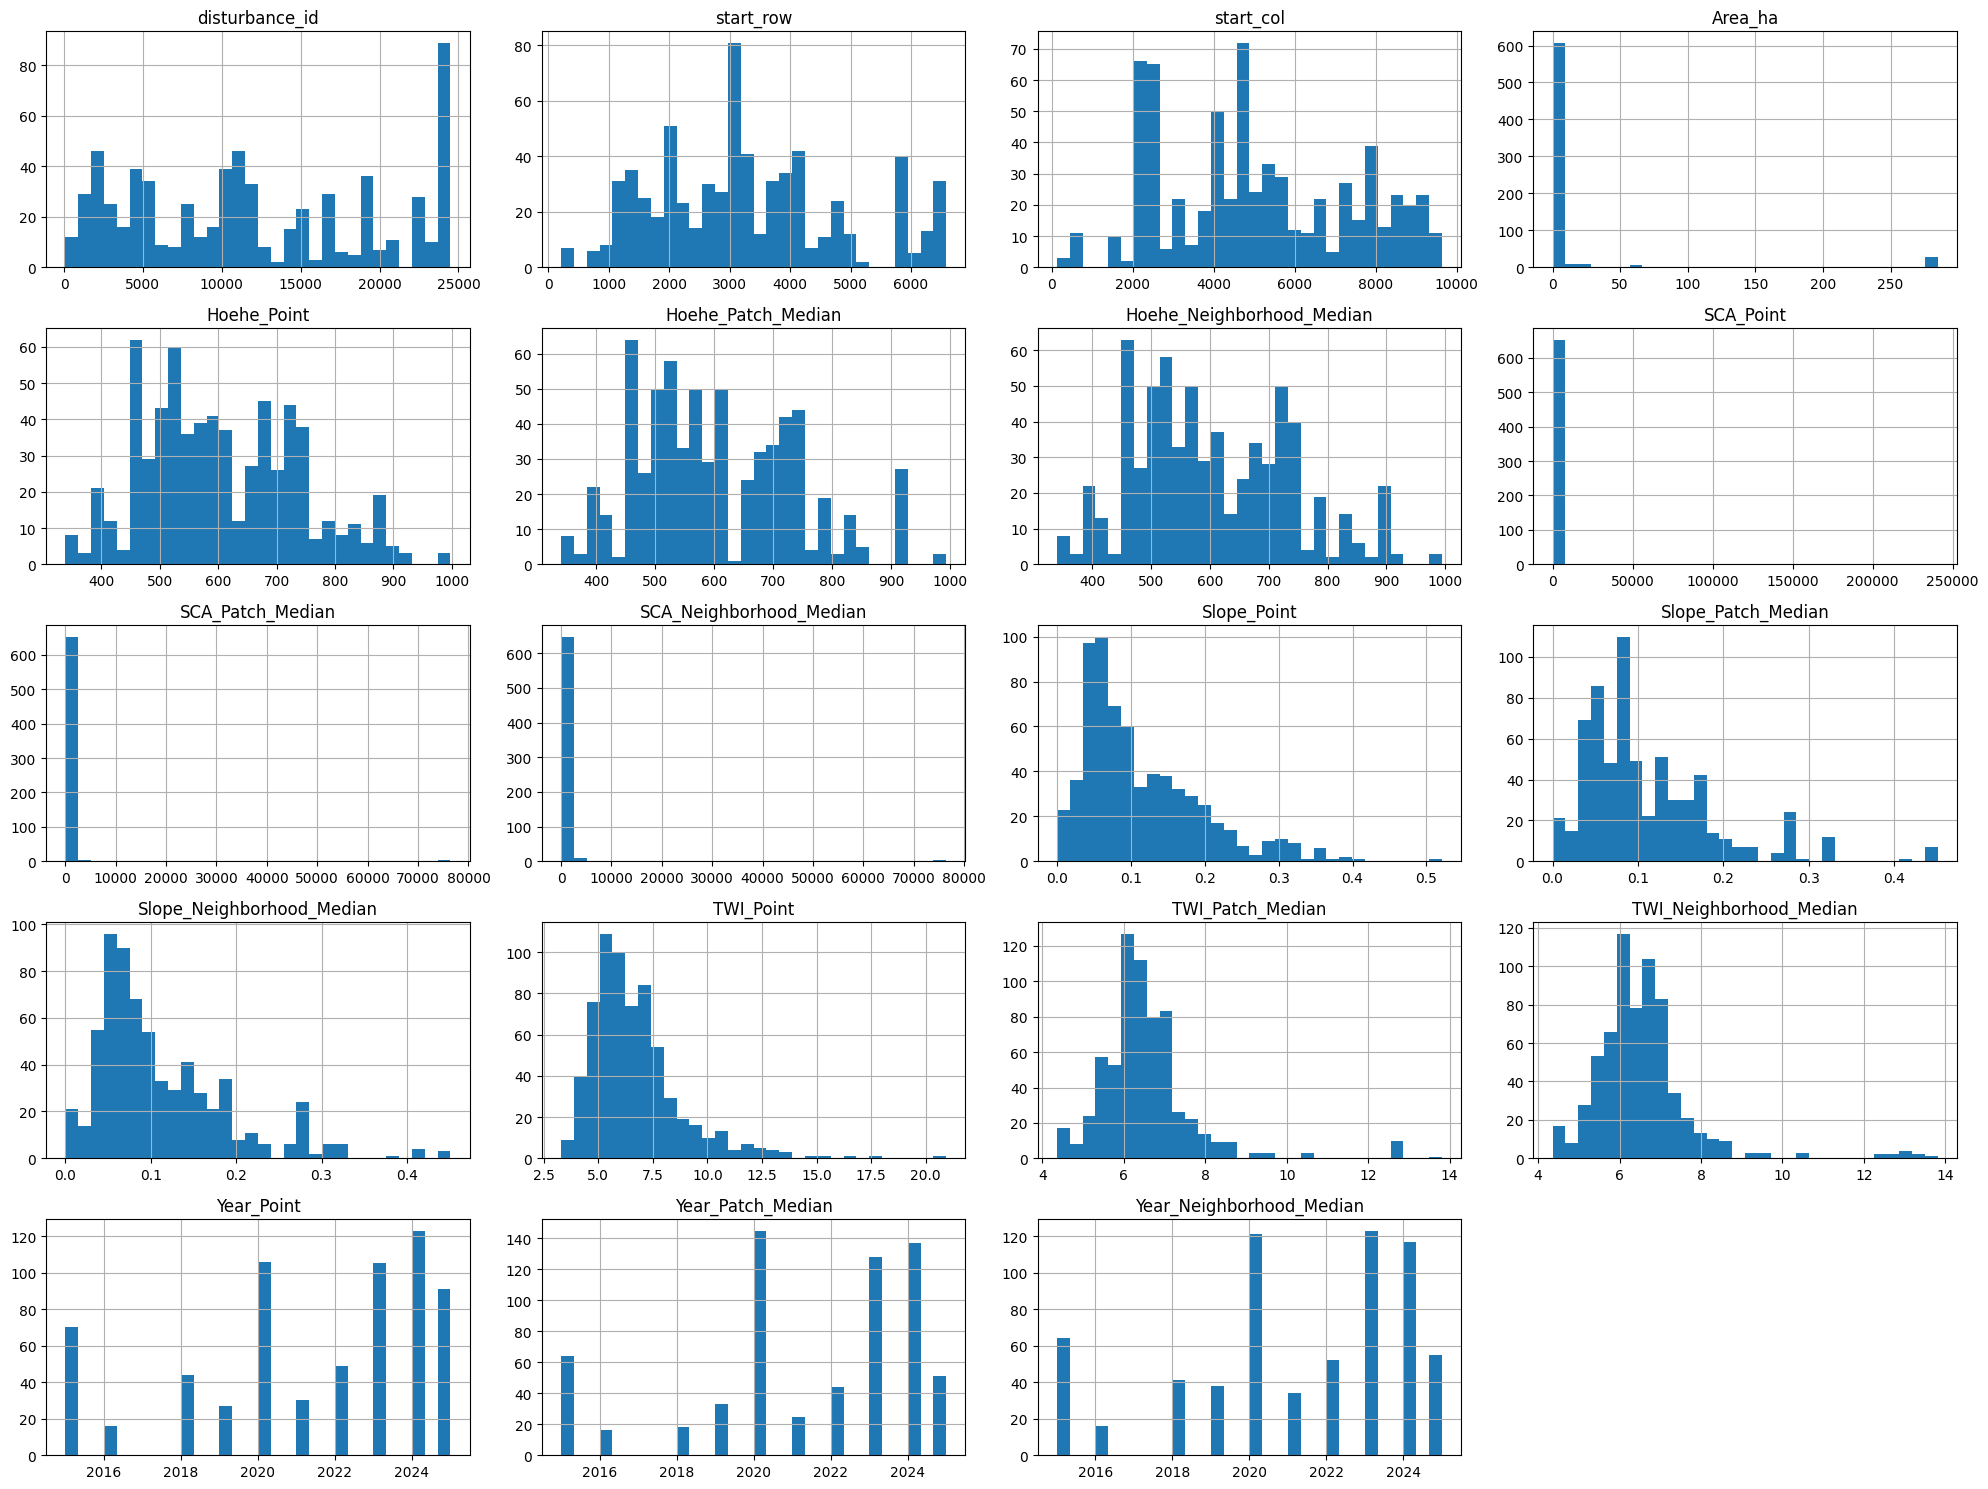

In [85]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

gdpk_fp = r"..\data\edit\Alba_dist_combined_v3\fichtelforst.gpkg"

# Layer 
layers = gpd.list_layers(gdpk_fp)
print(layers)

gdf_noRoadsPoints = gpd.read_file(gdpk_fp, layer="noRoads_points_100m")


# Unique values sorted
eindeutige_sorted = sorted(gdf_noRoadsPoints.Year_Neighborhood_Median.unique())
print("\n--- Sortierte eindeutige Werte ---")
df_unique = pd.DataFrame({
    'Unique Values': eindeutige_sorted
})
print(df_unique.to_string(index=False))


gdf_noRoadsPoints.hist(figsize=(20, 15), bins=30)
plt.tight_layout()




In [ ]:
import rasterio
import pandas as pd
import numpy as np

RASTER_PATH = r"..\data\edit\Alba_dist_combined_v3\disturbance_combined_pixel_year_10m.tif"

with rasterio.open(RASTER_PATH) as src:
    # Lese das Band als NumPy-Array
    lulc_band = src.read(1)
    
    # Nutze np.unique, um Werte und deren Anzahl zu finden
    eindeutige_werte, anzahl = np.unique(lulc_band, return_counts=True)
    
    # Kombinieren für einen Report
    report = dict(zip(eindeutige_werte, anzahl))
    
    # Umwandeln in DataFrame für schöne Tabellenausgabe
    df = pd.DataFrame(list(report.items()), columns=['Year', 'Pixel Count'])
    df['Year'] = df['Year'].astype(int)
    df['Pixel Count'] = df['Pixel Count'].astype(int)
    df = df.sort_values('Year')
    
    print(df.to_string(index=False))

 Year  Pixel Count
    0     67757287
 2015        83034
 2016        48483
 2017         9269
 2018        68800
 2019        88034
 2020        97885
 2021        60007
 2022        77754
 2023       149352
 2024       165269
 2025       134891
